In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Mon Oct 11 17:26:15 PDT 2021


In [2]:
%load_ext autoreload
%autoreload 2

# Define directories for saving plots

In [3]:
csr.get_count_data_path('4.5.2')

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.2_x_factor/ciff_sam/2021_09_29_12_12_47/count_data/'

In [4]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation

ethiopia.hdf  v1.3_causes   v2.1_gbd_2020_wasting	   v2.5_stunting
v1.0_causes   v1.4_causes   v2.3_wasting_birth_prevalence
v1.2_causes   v2.0_wasting  v2.4_corrected_fertility


In [5]:
# project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v4.5.2_x_factor'
model_timestamp = '2021_09_29_12_12_47'
username = 'ndbs'

In [6]:
# model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

# Load data and compute total person time

Total person-time is now computed in the data-cleaning step.

In [7]:
data = csr.VivariumResults.cleaned_from_model_spec('4.5.2')
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [8]:
data.person_time

age  input_draw      measure           scenario     sex  \
0         1-5_months          29  person_time           baseline  female   
1         1-5_months          29  person_time           baseline  female   
2         1-5_months          29  person_time           baseline  female   
3         1-5_months          29  person_time           baseline  female   
...              ...         ...          ...                ...     ...   
86396  late_neonatal         946  person_time  wasting_treatment    male   
86397  late_neonatal         946  person_time  wasting_treatment    male   
86398  late_neonatal         946  person_time  wasting_treatment    male   
86399  late_neonatal         946  person_time  wasting_treatment    male   

          sq_lns wasting_treatment x_factor  x_factor_effect  year      value  
0        covered           covered     cat1              1.1  2022   0.000000  
1        covered           covered     cat1              1.1  2023   0.000000  
2        covered           covered     cat1              1.1  2024   0.000000  
3        covered           covered     cat1              1.1  2025   0.000000  
...          ...               ...      ...              ...   ...        ...  
86396  uncovered         uncovered     cat2              1.5  2023  50.591376  
86397  uncovered         uncovered     cat2              1.5  2024  52.776181  
86398  uncovered         uncovered     cat2              1.5  2025  52.197125  
86399  uncovered         uncovered     cat2              1.5  2026  49.886379  

[86400 rows x 11 columns]

# Add `'x_factor_effect'` to the index columns

We can think of the scenario as being determined by the scenario name and the x-factor effect size. Thus, the x-factor effect size needs to get added to the index columns in order to properly match data when computing ratios, etc.

Eventuallly, it may be better to implement the functions in `vivarium_output_processing` in a class rather than globally in the module itself, so that different instances can be created that could have differnt sets of index columns in the same program. This would be useful if you want to compare two model versions, one of which has the x-factor and the other doesn't; currently there's not an easy way to do that.

Another strategy would be to rename the `'scenario'` column `'scenario_name'`, and create a new `'scenario'` column that combines the scenario name and x-factor effect size (e.g. `'baseline_1.1'`) -- that could be done in the data-cleaning step, and then the global variables wouldn't need to be modified. Actually, I think this is probably a good idea in general so that all the processing of scenarios can be handled in a uniform way.

In [9]:
vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario', 'x_factor_effect']

# It looks like total person time varies very little by X-factor effect

In [10]:
pt_by_age_sex_year = vp.stratify(data.person_time, ['age', 'sex', 'year'])
pt_by_age_sex_year

age     sex  year  input_draw           scenario  \
0         1-5_months  female  2022          29           baseline   
1         1-5_months  female  2022          29           baseline   
2         1-5_months  female  2022          29           baseline   
3         1-5_months  female  2022          29           baseline   
...              ...     ...   ...         ...                ...   
10796  late_neonatal    male  2026         946  wasting_treatment   
10797  late_neonatal    male  2026         946  wasting_treatment   
10798  late_neonatal    male  2026         946  wasting_treatment   
10799  late_neonatal    male  2026         946  wasting_treatment   

       x_factor_effect        value  
0                  1.1  4325.609856  
1                  1.2  4325.609856  
2                  1.3  4325.609856  
3                  1.4  4325.609856  
...                ...          ...  
10796              1.2   613.582478  
10797              1.3   613.582478  
10798              1.4   613.582478  
10799              1.5   613.582478  

[10800 rows x 7 columns]

In [11]:
pt_mean_sd_over_x_factor_effect = pt_by_age_sex_year.groupby(
    ['scenario', 'input_draw', 'age', 'sex', 'year']
)['value'].agg(['mean', 'std'])
pt_mean_sd_over_x_factor_effect
# vp.marginalize(data.person_time, ['sq_lns', 'wasting_treatment', 'x_factor', 'year'])

mean  \
scenario          input_draw age           sex    year                
baseline          29         1-5_months    female 2022  4325.609856   
                                                  2023  4305.196441   
                                                  2024  4394.783025   
                                                  2025  4391.889117   
...                                                             ...   
wasting_treatment 946        late_neonatal male   2023   633.241615   
                                                  2024   613.998631   
                                                  2025   622.067077   
                                                  2026   613.582478   

                                                                 std  
scenario          input_draw age           sex    year                
baseline          29         1-5_months    female 2022  7.876455e-13  
                                                  2023  6.431099e-13  
                                                  2024  0.000000e+00  
                                                  2025  6.431099e-13  
...                                                              ...  
wasting_treatment 946        late_neonatal male   2023  0.000000e+00  
                                                  2024  5.684342e-14  
                                                  2025  5.684342e-14  
                                                  2026  5.684342e-14  

[2160 rows x 2 columns]

In [12]:
pt_mean_sd_over_x_factor_effect['std'].describe()

count    2.160000e+03
mean     4.572365e-01
std      8.294373e-01
min      0.000000e+00
25%      2.009718e-14
50%      1.438037e-12
75%      5.380377e-01
max      4.541497e+00
Name: std, dtype: float64

# Compute wasting prevalence by scenario, aggregated over everything

Hmm, I can't do exactly this with my new `get_prevalence` function because I'm filtering out a year first... I could potentially add a "filter terms" argument to the functions in the `ciff_sam_results` module.

In [13]:
query_string = "year>'2022'" # Filter out pre-intervention years
wasting_prevalence_post_intervention = vp.ratio(
    data.wasting_state_person_time.query(query_string),
    data.person_time.query(query_string),
    strata=[], # Stratifying by nothing groups by scenario and draw
    numerator_broadcast='wasting_state', # Compute prevalence of all categories simultaneously
    multiplier=100, # Convert units to percent
)
csr.to_ordered_categoricals(wasting_prevalence_post_intervention, inplace=True)
wasting_prevalence_post_intervention

input_draw           scenario  x_factor_effect  \
0            29           baseline              1.1   
1            29           baseline              1.1   
2            29           baseline              1.1   
3            29           baseline              1.1   
..          ...                ...              ...   
716         946  wasting_treatment              1.5   
717         946  wasting_treatment              1.5   
718         946  wasting_treatment              1.5   
719         946  wasting_treatment              1.5   

                    wasting_state      value  numerator_measure  \
0              mild_child_wasting  21.475713  state_person_time   
1     moderate_acute_malnutrition   8.012110  state_person_time   
2       severe_acute_malnutrition   1.930103  state_person_time   
3    susceptible_to_child_wasting  68.582074  state_person_time   
..                            ...        ...                ...   
716            mild_child_wasting  22.098205  state_person_time   
717   moderate_acute_malnutrition   6.953529  state_person_time   
718     severe_acute_malnutrition   1.642355  state_person_time   
719  susceptible_to_child_wasting  69.305912  state_person_time   

    denominator_measure  multiplier  
0           person_time         100  
1           person_time         100  
2           person_time         100  
3           person_time         100  
..                  ...         ...  
716         person_time         100  
717         person_time         100  
718         person_time         100  
719         person_time         100  

[720 rows x 8 columns]

In [14]:
wasting_results = vp.describe(wasting_prevalence_post_intervention)['mean'].unstack('wasting_state')
wasting_results

wasting_state                                                              severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                              
person_time         100        state_person_time baseline 1.1                               1.883823   
                                                          1.2                               1.886663   
                                                          1.3                               1.896536   
                                                          1.4                               1.905757   
...                                                                                              ...   
                                                 sqlns    1.2                               1.457664   
                                                          1.3                               1.465293   
                                                          1.4                               1.472418   
                                                          1.5                               1.482472   

wasting_state                                                              moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time baseline 1.1                                 7.949866   
                                                          1.2                                 7.949418   
                                                          1.3                                 7.945242   
                                                          1.4                                 7.939219   
...                                                                                                ...   
                                                 sqlns    1.2                                 6.147155   
                                                          1.3                                 6.146079   
                                                          1.4                                 6.141460   
                                                          1.5                                 6.142309   

wasting_state                                                              mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                       
person_time         100        state_person_time baseline 1.1                       21.499195   
                                                          1.2                       21.506549   
                                                          1.3                       21.488940   
                                                          1.4                       21.478378   
...                                                                                       ...   
                                                 sqlns    1.2                       23.006910   
                                                          1.3                       22.993371   
                                                          1.4                       22.980538   
                                                          1.5                       22.982252   

wasting_state                                                              susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time baseline 1.1                                 68.667115  
                                                          1.2                                 68.657370  
                                                          1.3                                 68.669282  
                                                          1.4                             

# Display wasting state prevalnces by X-factor effect in each scenario

In [15]:
wasting_results.query("scenario=='baseline'")

wasting_state                                                              severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                              
person_time         100        state_person_time baseline 1.1                               1.883823   
                                                          1.2                               1.886663   
                                                          1.3                               1.896536   
                                                          1.4                               1.905757   
                                                          1.5                               1.915992   

wasting_state                                                              moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time baseline 1.1                                 7.949866   
                                                          1.2                                 7.949418   
                                                          1.3                                 7.945242   
                                                          1.4                                 7.939219   
                                                          1.5                                 7.935566   

wasting_state                                                              mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                       
person_time         100        state_person_time baseline 1.1                       21.499195   
                                                          1.2                       21.506549   
                                                          1.3                       21.488940   
                                                          1.4                       21.478378   
                                                          1.5                       21.464860   

wasting_state                                                              susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time baseline 1.1                                 68.667115  
                                                          1.2                                 68.657370  
                                                          1.3                                 68.669282  
                                                          1.4                                 68.676645  
                                                          1.5                                 68.683581

In [16]:
wasting_results.query("scenario=='wasting_treatment'")

wasting_state                                                                       severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                              
person_time         100        state_person_time wasting_treatment 1.1                               1.596260   
                                                                   1.2                               1.597814   
                                                                   1.3                               1.606553   
                                                                   1.4                               1.614968   
                                                                   1.5                               1.622508   

wasting_state                                                                       moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time wasting_treatment 1.1                                 6.900566   
                                                                   1.2                                 6.900871   
                                                                   1.3                                 6.898865   
                                                                   1.4                                 6.895666   
                                                                   1.5                                 6.893656   

wasting_state                                                                       mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                       
person_time         100        state_person_time wasting_treatment 1.1                       22.389413   
                                                                   1.2                       22.393291   
                                                                   1.3                       22.375486   
                                                                   1.4                       22.366840   
                                                                   1.5                       22.354118   

wasting_state                                                                       susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time wasting_treatment 1.1                                 69.113761  
                                                                   1.2                                 69.108024  
                                                                   1.3                                 69.119096  
                                                                   1.4                                 69.122527  
                                                                   1.5                                 69.129718

In [17]:
wasting_results.query("scenario=='sqlns'")

wasting_state                                                              severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                              
person_time         100        state_person_time sqlns    1.1                               1.454969   
                                                          1.2                               1.457664   
                                                          1.3                               1.465293   
                                                          1.4                               1.472418   
                                                          1.5                               1.482472   

wasting_state                                                              moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time sqlns    1.1                                 6.144714   
                                                          1.2                                 6.147155   
                                                          1.3                                 6.146079   
                                                          1.4                                 6.141460   
                                                          1.5                                 6.142309   

wasting_state                                                              mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario x_factor_effect                       
person_time         100        state_person_time sqlns    1.1                       23.012922   
                                                          1.2                       23.006910   
                                                          1.3                       22.993371   
                                                          1.4                       22.980538   
                                                          1.5                       22.982252   

wasting_state                                                              susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario x_factor_effect                                
person_time         100        state_person_time sqlns    1.1                                 69.387395  
                                                          1.2                                 69.388271  
                                                          1.3                                 69.395257  
                                                          1.4                                 69.405583  
                                                          1.5                                 69.392967

# Display wasting state prevalnces by scenario for each X-factor effect 

In [18]:
wasting_results.query("x_factor_effect==1.1")

wasting_state                                                                       severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                              
person_time         100        state_person_time baseline          1.1                               1.883823   
                                                 wasting_treatment 1.1                               1.596260   
                                                 sqlns             1.1                               1.454969   

wasting_state                                                                       moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.1                                 7.949866   
                                                 wasting_treatment 1.1                                 6.900566   
                                                 sqlns             1.1                                 6.144714   

wasting_state                                                                       mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                       
person_time         100        state_person_time baseline          1.1                       21.499195   
                                                 wasting_treatment 1.1                       22.389413   
                                                 sqlns             1.1                       23.012922   

wasting_state                                                                       susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.1                                 68.667115  
                                                 wasting_treatment 1.1                                 69.113761  
                                                 sqlns             1.1                                 69.387395

In [19]:
wasting_results.query("x_factor_effect==1.3")

wasting_state                                                                       severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                              
person_time         100        state_person_time baseline          1.3                               1.896536   
                                                 wasting_treatment 1.3                               1.606553   
                                                 sqlns             1.3                               1.465293   

wasting_state                                                                       moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.3                                 7.945242   
                                                 wasting_treatment 1.3                                 6.898865   
                                                 sqlns             1.3                                 6.146079   

wasting_state                                                                       mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                       
person_time         100        state_person_time baseline          1.3                       21.488940   
                                                 wasting_treatment 1.3                       22.375486   
                                                 sqlns             1.3                       22.993371   

wasting_state                                                                       susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.3                                 68.669282  
                                                 wasting_treatment 1.3                                 69.119096  
                                                 sqlns             1.3                                 69.395257

In [20]:
wasting_results.query("x_factor_effect==1.5")

wasting_state                                                                       severe_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                              
person_time         100        state_person_time baseline          1.5                               1.915992   
                                                 wasting_treatment 1.5                               1.622508   
                                                 sqlns             1.5                               1.482472   

wasting_state                                                                       moderate_acute_malnutrition  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.5                                 7.935566   
                                                 wasting_treatment 1.5                                 6.893656   
                                                 sqlns             1.5                                 6.142309   

wasting_state                                                                       mild_child_wasting  \
denominator_measure multiplier numerator_measure scenario          x_factor_effect                       
person_time         100        state_person_time baseline          1.5                       21.464860   
                                                 wasting_treatment 1.5                       22.354118   
                                                 sqlns             1.5                       22.982252   

wasting_state                                                                       susceptible_to_child_wasting  
denominator_measure multiplier numerator_measure scenario          x_factor_effect                                
person_time         100        state_person_time baseline          1.5                                 68.683581  
                                                 wasting_treatment 1.5                                 69.129718  
                                                 sqlns             1.5                                 69.392967

# Plot wasting state prevalence by year for each scenario and X-factor effect

In [21]:
# query_string = "year >= '2022'" 
# wasting_prevalence_by_year = vo.ratio(
#     data.wasting_state_person_time.query(query_string),
#     data.person_time.query(query_string),
#     strata=['year'], # Stratifying by nothing groups by scenario and draw
#     numerator_broadcast='wasting_state', # Compute prevalence of all categories simultaneously
#     multiplier=100, # Convert units to percent
# )
wasting_prevalence_by_year = csr.get_prevalence(data, 'wasting', strata='year', multiplier=100)
csr.to_ordered_categoricals(wasting_prevalence_by_year, inplace=True)
wasting_prevalence_by_year

year  input_draw           scenario  x_factor_effect  \
0     2022          29           baseline              1.1   
1     2022          29           baseline              1.1   
2     2022          29           baseline              1.1   
3     2022          29           baseline              1.1   
...    ...         ...                ...              ...   
3596  2026         946  wasting_treatment              1.5   
3597  2026         946  wasting_treatment              1.5   
3598  2026         946  wasting_treatment              1.5   
3599  2026         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  21.154552  state_person_time   
1      moderate_acute_malnutrition   7.918320  state_person_time   
2        severe_acute_malnutrition   1.927363  state_person_time   
3     susceptible_to_child_wasting  68.999765  state_person_time   
...                            ...        ...                ...   
3596            mild_child_wasting  21.932427  state_person_time   
3597   moderate_acute_malnutrition   6.867855  state_person_time   
3598     severe_acute_malnutrition   1.594966  state_person_time   
3599  susceptible_to_child_wasting  69.604753  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
3596         person_time         100  
3597         person_time         100  
3598         person_time         100  
3599         person_time         100  

[3600 rows x 9 columns]

In [22]:
5*12*3*5*4

3600

<AxesSubplot:xlabel='year'>

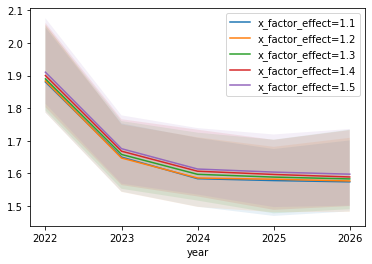

In [23]:
def plot_over_time_by_column(df, colname, ylabel='', title='', uncertainty=True, ax=None):
    """Plot mean value vs. year for each age, with (lower, upper) uncertainty band."""
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    agg = df.groupby([colname, 'year'])['value'].describe(percentiles=[.025, .975])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax.plot(years, values['mean'], label=f"{colname}={col_val}")
        if uncertainty:
            ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

scenario = 'wasting_treatment'
wasting_state = 'severe_acute_malnutrition'
query_string = "scenario==@scenario and wasting_state==@wasting_state"
plot_over_time_by_column(wasting_prevalence_by_year.query(query_string), 'x_factor_effect')

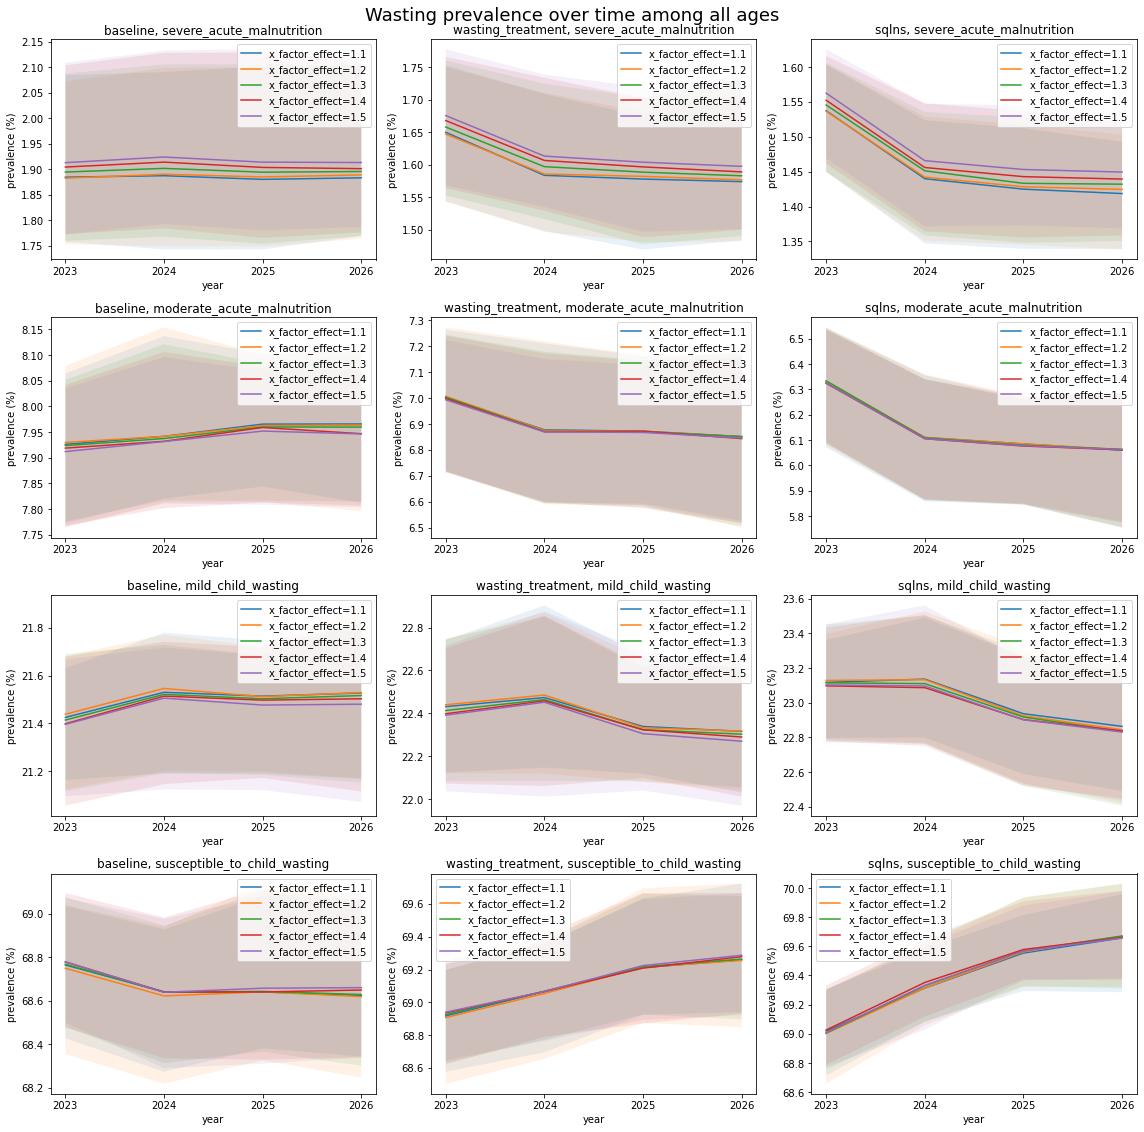

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))
for ws_num, wasting_state in enumerate(csr.ordered_wasting_states):
    for s_num, scenario in enumerate(csr.ordered_scenarios):
#         print(scenario, wasting_state)
        query_string = "year > '2022' and scenario==@scenario and wasting_state==@wasting_state"
        plot_over_time_by_column(
            wasting_prevalence_by_year.query(query_string),
            'x_factor_effect',
            title=f"{scenario}, {wasting_state}",
            ylabel="prevalence (%)",
            ax=axs[ws_num, s_num],
        )
fig.suptitle("Wasting prevalence over time among all ages", fontsize=18)
fig.tight_layout()

In [25]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_all_ages_with_uncertainty.pdf")

# Compute prevalence stratified by year and age

In [26]:
wasting_prevalence_by_year_and_age = csr.get_prevalence(data, 'wasting', strata=['year', 'age'], multiplier=100)
csr.to_ordered_categoricals(wasting_prevalence_by_year_and_age, inplace=True)
wasting_prevalence_by_year_and_age

year            age  input_draw           scenario  x_factor_effect  \
0      2022     1-5_months          29           baseline              1.1   
1      2022     1-5_months          29           baseline              1.1   
2      2022     1-5_months          29           baseline              1.1   
3      2022     1-5_months          29           baseline              1.1   
...     ...            ...         ...                ...              ...   
21596  2026  late_neonatal         946  wasting_treatment              1.5   
21597  2026  late_neonatal         946  wasting_treatment              1.5   
21598  2026  late_neonatal         946  wasting_treatment              1.5   
21599  2026  late_neonatal         946  wasting_treatment              1.5   

                      wasting_state      value  numerator_measure  \
0                mild_child_wasting  20.385463  state_person_time   
1       moderate_acute_malnutrition   9.000230  state_person_time   
2         severe_acute_malnutrition   3.067472  state_person_time   
3      susceptible_to_child_wasting  67.546834  state_person_time   
...                             ...        ...                ...   
21596            mild_child_wasting  20.004149  state_person_time   
21597   moderate_acute_malnutrition   8.994278  state_person_time   
21598     severe_acute_malnutrition   3.286887  state_person_time   
21599  susceptible_to_child_wasting  67.714686  state_person_time   

      denominator_measure  multiplier  
0             person_time         100  
1             person_time         100  
2             person_time         100  
3             person_time         100  
...                   ...         ...  
21596         person_time         100  
21597         person_time         100  
21598         person_time         100  
21599         person_time         100  

[21600 rows x 10 columns]

In [27]:
wasting_prevalence_by_year_and_age.query("year>'2022' and wasting_state=='severe_acute_malnutrition'")

year            age  input_draw           scenario  x_factor_effect  \
4322   2023     1-5_months          29           baseline              1.1   
4326   2023     1-5_months          29           baseline              1.2   
4330   2023     1-5_months          29           baseline              1.3   
4334   2023     1-5_months          29           baseline              1.4   
...     ...            ...         ...                ...              ...   
21586  2026  late_neonatal         946  wasting_treatment              1.2   
21590  2026  late_neonatal         946  wasting_treatment              1.3   
21594  2026  late_neonatal         946  wasting_treatment              1.4   
21598  2026  late_neonatal         946  wasting_treatment              1.5   

                   wasting_state     value  numerator_measure  \
4322   severe_acute_malnutrition  2.996760  state_person_time   
4326   severe_acute_malnutrition  2.996760  state_person_time   
4330   severe_acute_malnutrition  2.996760  state_person_time   
4334   severe_acute_malnutrition  2.996760  state_person_time   
...                          ...       ...                ...   
21586  severe_acute_malnutrition  3.286887  state_person_time   
21590  severe_acute_malnutrition  3.286887  state_person_time   
21594  severe_acute_malnutrition  3.286887  state_person_time   
21598  severe_acute_malnutrition  3.286887  state_person_time   

      denominator_measure  multiplier  
4322          person_time         100  
4326          person_time         100  
4330          person_time         100  
4334          person_time         100  
...                   ...         ...  
21586         person_time         100  
21590         person_time         100  
21594         person_time         100  
21598         person_time         100  

[4320 rows x 10 columns]

<AxesSubplot:xlabel='year'>

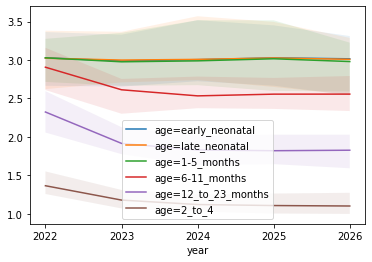

In [28]:
scenario = 'wasting_treatment'
wasting_state = 'severe_acute_malnutrition'
query_string = "scenario==@scenario and wasting_state==@wasting_state"
plot_over_time_by_column(wasting_prevalence_by_year_and_age.query(query_string), 'age')

# Plot prevalence over time for age > 6mo

In [29]:
over_6mo = list(
    csr.ages_categorical[(csr.ages_categorical >= '6-11_months') & (csr.ages_categorical != 'all_ages')]
)
wasting_prevalence_by_year_and_age_over_6mo = wasting_prevalence_by_year_and_age.query(
    "age in @over_6mo and year>'2022'")
wasting_prevalence_by_year_and_age_over_6mo

year              age  input_draw           scenario  x_factor_effect  \
5040   2023  12_to_23_months          29           baseline              1.1   
5041   2023  12_to_23_months          29           baseline              1.1   
5042   2023  12_to_23_months          29           baseline              1.1   
5043   2023  12_to_23_months          29           baseline              1.1   
...     ...              ...         ...                ...              ...   
20156  2026      6-11_months         946  wasting_treatment              1.5   
20157  2026      6-11_months         946  wasting_treatment              1.5   
20158  2026      6-11_months         946  wasting_treatment              1.5   
20159  2026      6-11_months         946  wasting_treatment              1.5   

                      wasting_state      value  numerator_measure  \
5040             mild_child_wasting  21.271228  state_person_time   
5041    moderate_acute_malnutrition   8.662980  state_person_time   
5042      severe_acute_malnutrition   2.327912  state_person_time   
5043   susceptible_to_child_wasting  67.737880  state_person_time   
...                             ...        ...                ...   
20156            mild_child_wasting  21.376420  state_person_time   
20157   moderate_acute_malnutrition   7.737312  state_person_time   
20158     severe_acute_malnutrition   2.565442  state_person_time   
20159  susceptible_to_child_wasting  68.320826  state_person_time   

      denominator_measure  multiplier  
5040          person_time         100  
5041          person_time         100  
5042          person_time         100  
5043          person_time         100  
...                   ...         ...  
20156         person_time         100  
20157         person_time         100  
20158         person_time         100  
20159         person_time         100  

[8640 rows x 10 columns]

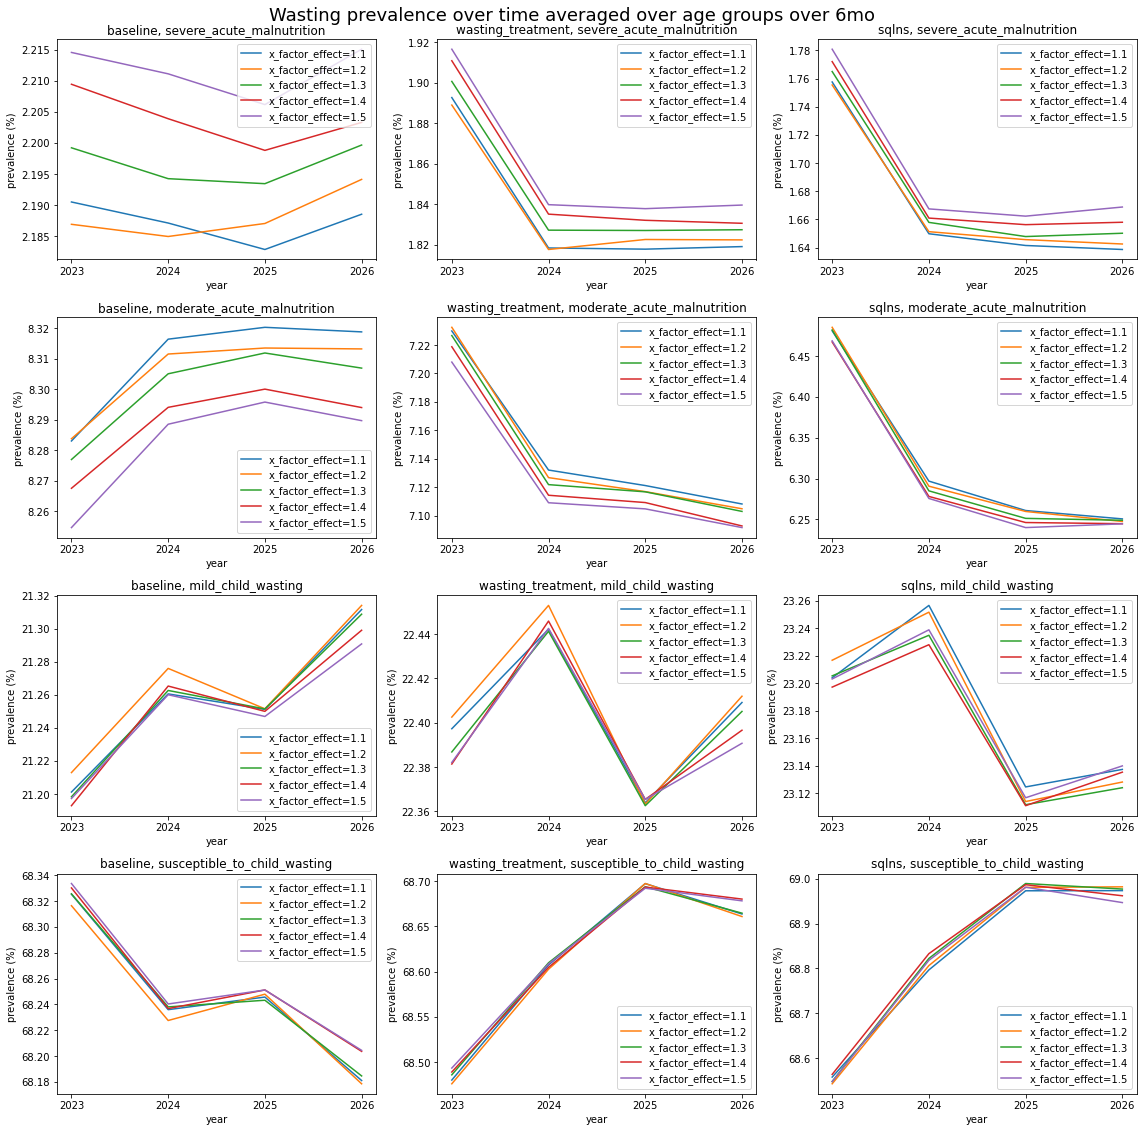

In [30]:
def plot_over_time_by_column_for_each_wasting_state_and_scenario(
    df, colname, ylabel='', suptitle='', uncertainty=True
):
    fig, axs = plt.subplots(4, 3, figsize=(16, 16))
    for ws_num, wasting_state in enumerate(csr.ordered_wasting_states):
        for s_num, scenario in enumerate(csr.ordered_scenarios):
    #         print(scenario, wasting_state)
            plot_over_time_by_column(
                df.query("scenario==@scenario and wasting_state==@wasting_state"),
                colname,
                title=f"{scenario}, {wasting_state}",
                ylabel=ylabel,
                uncertainty=uncertainty,
                ax=axs[ws_num, s_num],
            )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age_over_6mo, 
    'x_factor_effect', 
    ylabel="prevalence (%)",
    suptitle="Wasting prevalence over time averaged over age groups over 6mo",
    uncertainty=False,
);

In [31]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_over_6mo_averaged.pdf")

## Hmm, perhaps stratifying by age is the wrong way to look at it -- all age groups will be weighted equally vs. being weighted by person-time

## Instead, first filter to age groups > 6mo and then stratify by year only

In [32]:
wasting_prevalence_by_year_over_6mo = csr.get_prevalence(
    data, 'wasting', strata=['year'], prefilter_query=f"age in {over_6mo}", multiplier=100
)
wasting_prevalence_by_year_over_6mo

year  input_draw           scenario  x_factor_effect  \
0     2022          29           baseline              1.1   
1     2022          29           baseline              1.1   
2     2022          29           baseline              1.1   
3     2022          29           baseline              1.1   
...    ...         ...                ...              ...   
3596  2026         946  wasting_treatment              1.5   
3597  2026         946  wasting_treatment              1.5   
3598  2026         946  wasting_treatment              1.5   
3599  2026         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  21.240116  state_person_time   
1      moderate_acute_malnutrition   7.795280  state_person_time   
2        severe_acute_malnutrition   1.797212  state_person_time   
3     susceptible_to_child_wasting  69.167391  state_person_time   
...                            ...        ...                ...   
3596            mild_child_wasting  22.166768  state_person_time   
3597   moderate_acute_malnutrition   6.621542  state_person_time   
3598     severe_acute_malnutrition   1.410896  state_person_time   
3599  susceptible_to_child_wasting  69.800794  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
3596         person_time         100  
3597         person_time         100  
3598         person_time         100  
3599         person_time         100  

[3600 rows x 9 columns]

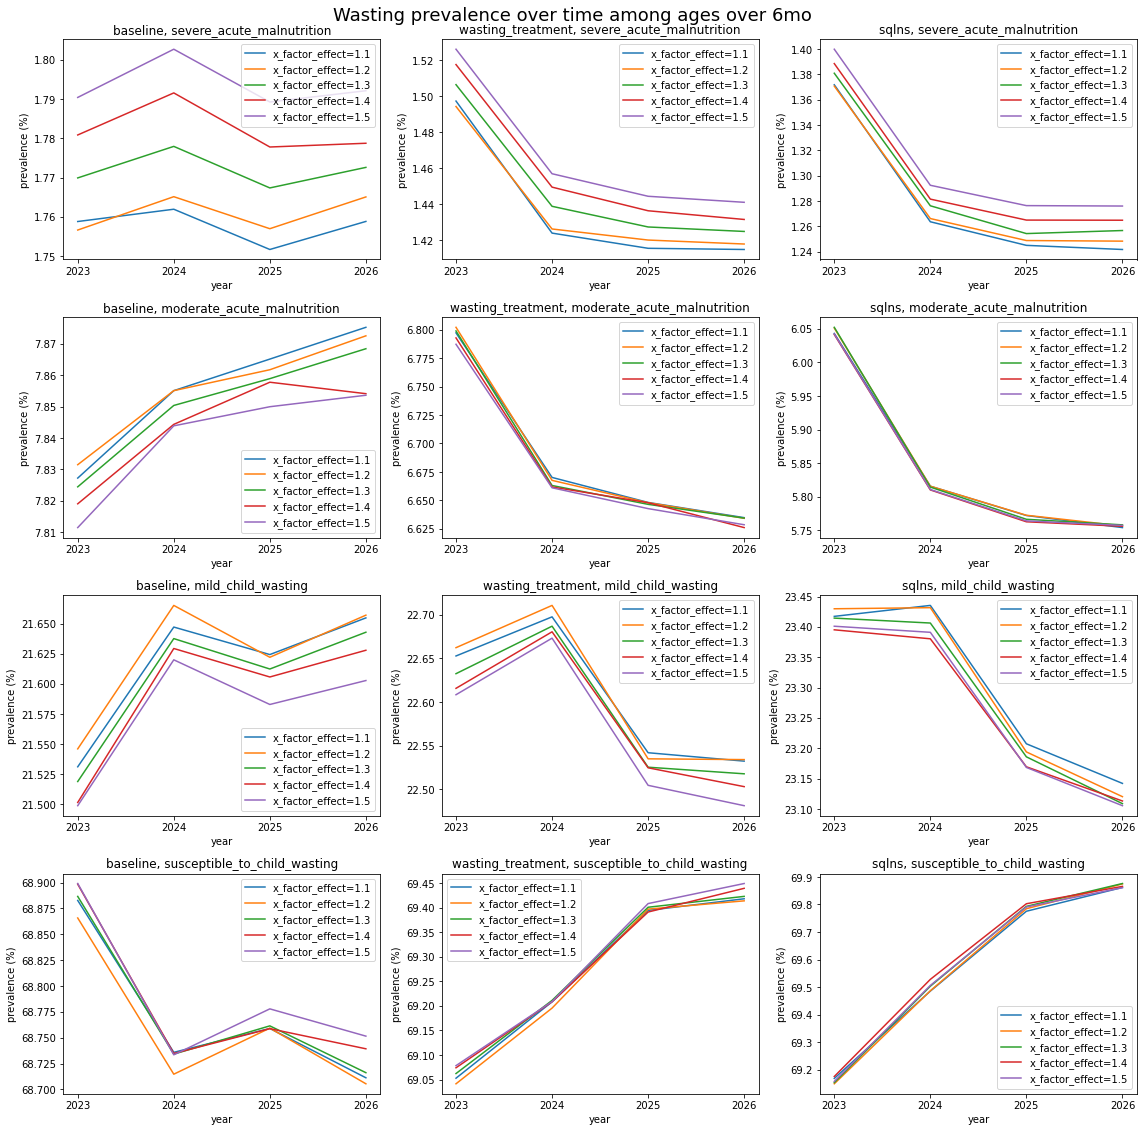

In [33]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_over_6mo.query("year>'2022'"), 
    'x_factor_effect', 
    ylabel="prevalence (%)",
    suptitle="Wasting prevalence over time among ages over 6mo",
    uncertainty=False,
);

In [34]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_over_6mo.pdf")

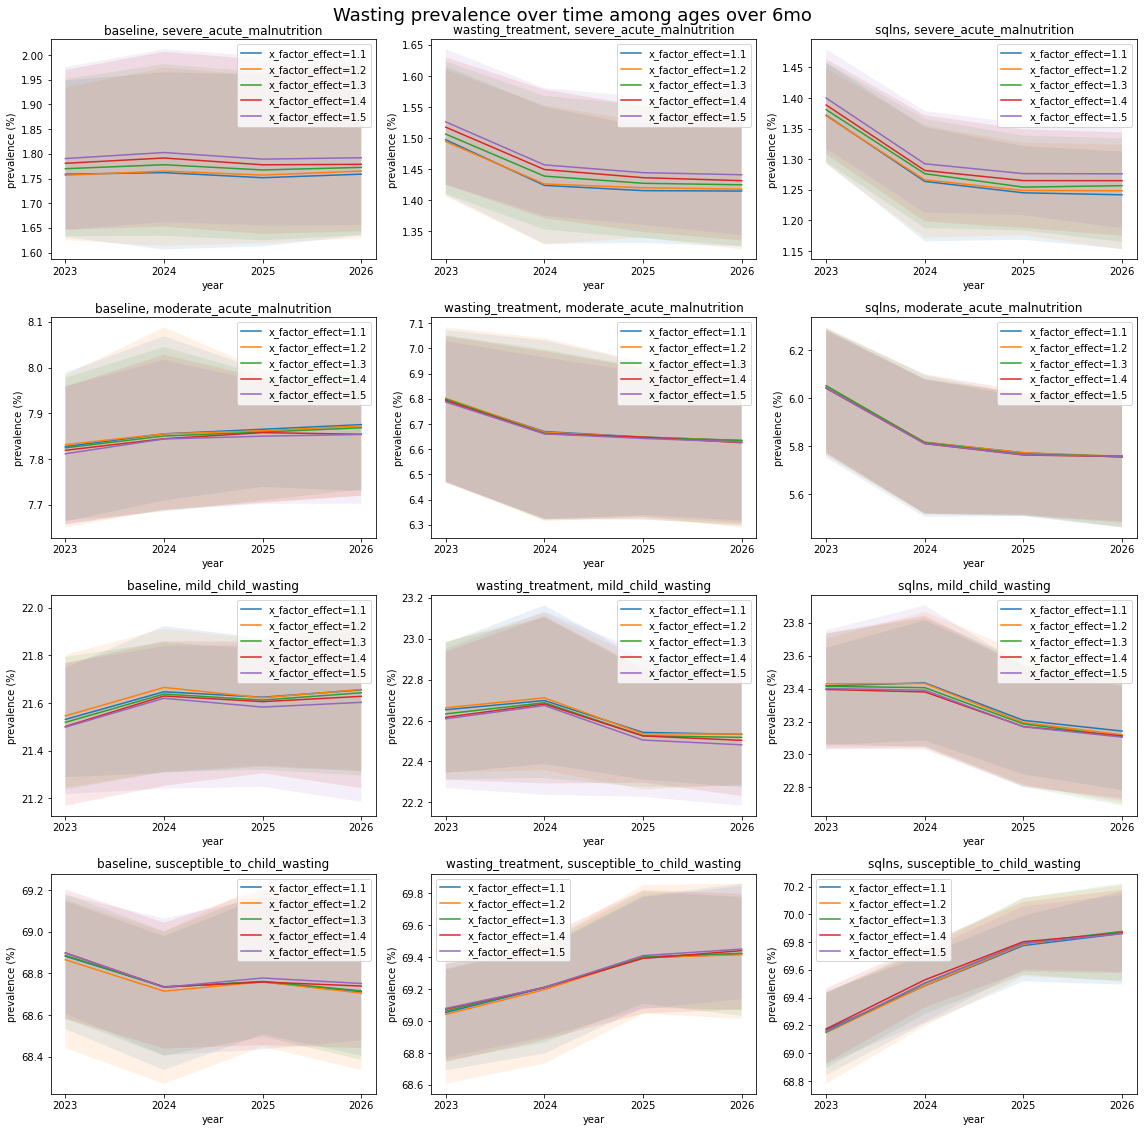

In [35]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_over_6mo.query("year>'2022'"), 
    'x_factor_effect', 
    ylabel="prevalence (%)",
    suptitle="Wasting prevalence over time among ages over 6mo",
    uncertainty=True,
)

In [36]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_over_6mo_with_uncertainty.pdf")

# Plot wasting prevalence for each age group over 6mo

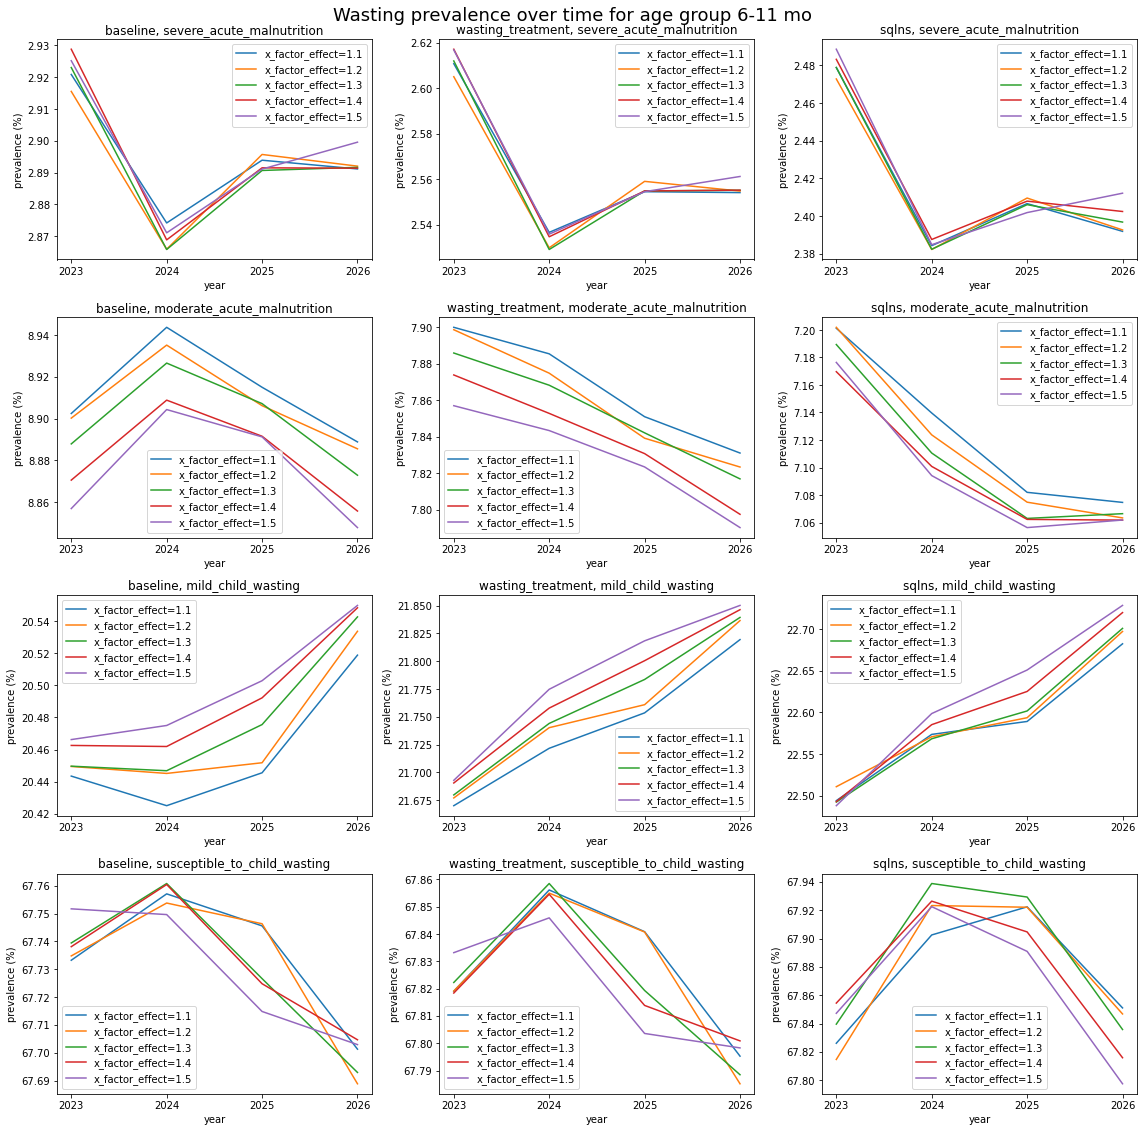

In [37]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022' and age=='6-11_months'"), 
    'x_factor_effect',
    ylabel="prevalence (%)",
    suptitle="Wasting prevalence over time for age group 6-11 mo",
    uncertainty=False
)

In [38]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_6-11_months.pdf")

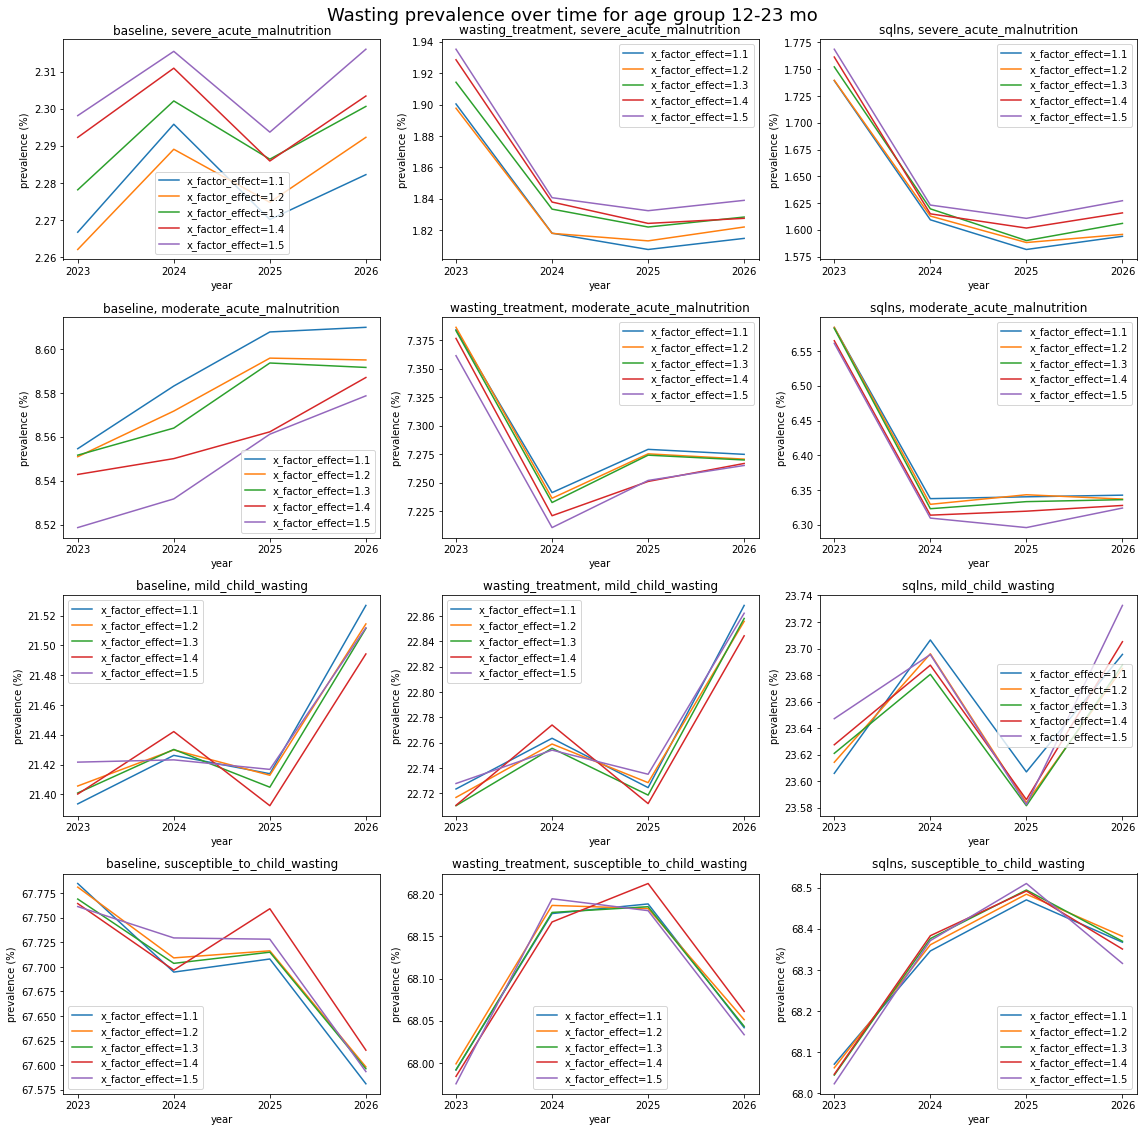

In [39]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022' and age=='12_to_23_months'"), 
    'x_factor_effect',
    "prevalence (%)",
    "Wasting prevalence over time for age group 12-23 mo",
    False
)

In [40]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_12-23_months.pdf")

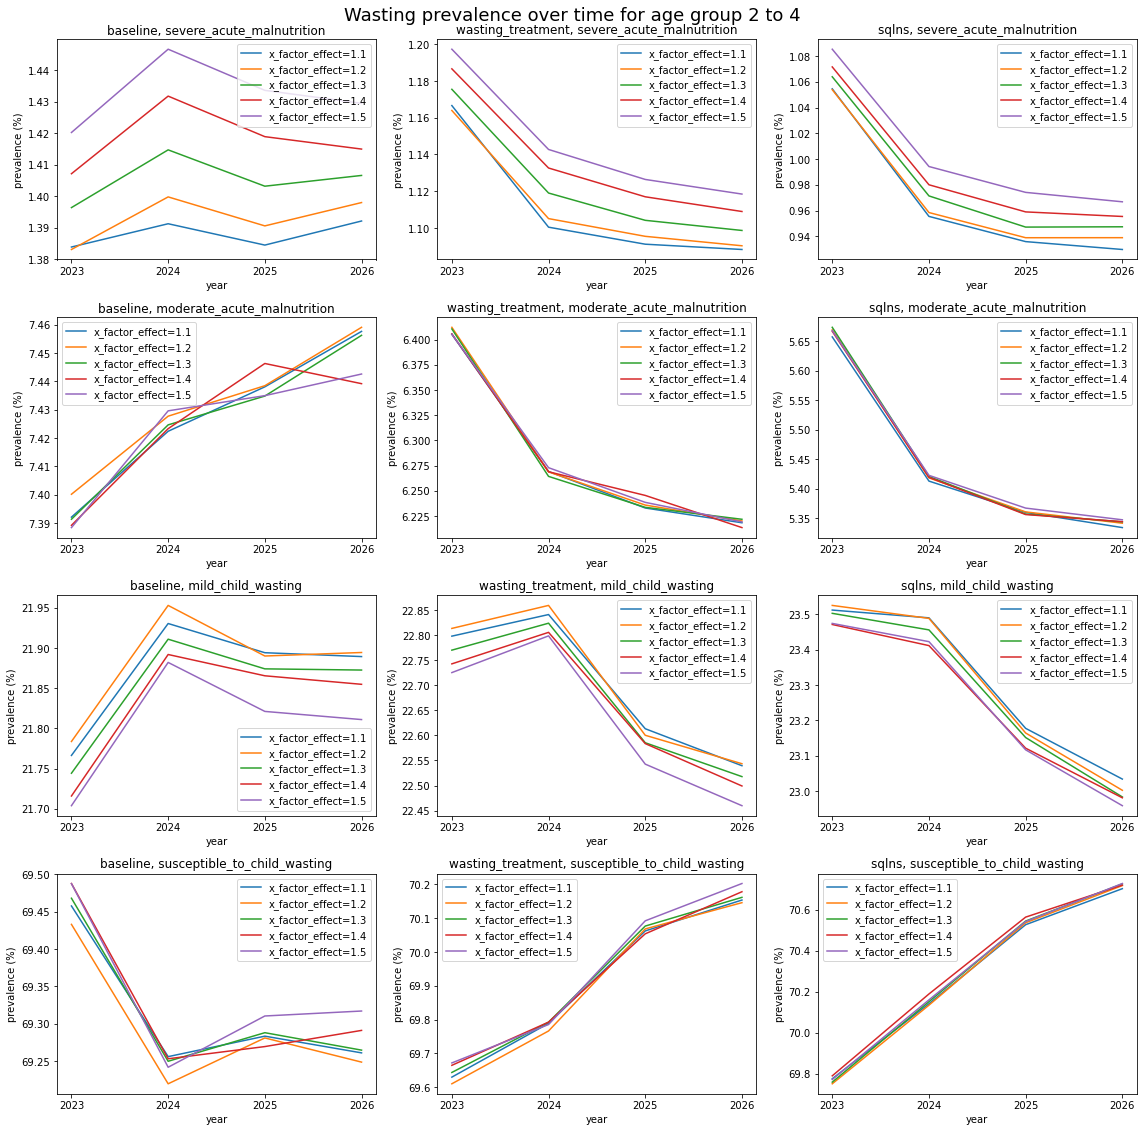

In [41]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022' and age=='2_to_4'"), 
    'x_factor_effect',
    "prevalence (%)",
    "Wasting prevalence over time for age group 2 to 4",
    uncertainty=False
)

In [42]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_2_to_4.pdf")

# Plot wasting prevalence under 6mo

In [43]:
wasting_prevalence_by_year_and_age_under_6mo = wasting_prevalence_by_year_and_age.query(
    "age not in @over_6mo and year>'2022'")
wasting_prevalence_by_year_and_age_under_6mo

year            age  input_draw           scenario  x_factor_effect  \
4320   2023     1-5_months          29           baseline              1.1   
4321   2023     1-5_months          29           baseline              1.1   
4322   2023     1-5_months          29           baseline              1.1   
4323   2023     1-5_months          29           baseline              1.1   
...     ...            ...         ...                ...              ...   
21596  2026  late_neonatal         946  wasting_treatment              1.5   
21597  2026  late_neonatal         946  wasting_treatment              1.5   
21598  2026  late_neonatal         946  wasting_treatment              1.5   
21599  2026  late_neonatal         946  wasting_treatment              1.5   

                      wasting_state      value  numerator_measure  \
4320             mild_child_wasting  20.663357  state_person_time   
4321    moderate_acute_malnutrition   8.820773  state_person_time   
4322      severe_acute_malnutrition   2.996760  state_person_time   
4323   susceptible_to_child_wasting  67.519110  state_person_time   
...                             ...        ...                ...   
21596            mild_child_wasting  20.004149  state_person_time   
21597   moderate_acute_malnutrition   8.994278  state_person_time   
21598     severe_acute_malnutrition   3.286887  state_person_time   
21599  susceptible_to_child_wasting  67.714686  state_person_time   

      denominator_measure  multiplier  
4320          person_time         100  
4321          person_time         100  
4322          person_time         100  
4323          person_time         100  
...                   ...         ...  
21596         person_time         100  
21597         person_time         100  
21598         person_time         100  
21599         person_time         100  

[8640 rows x 10 columns]

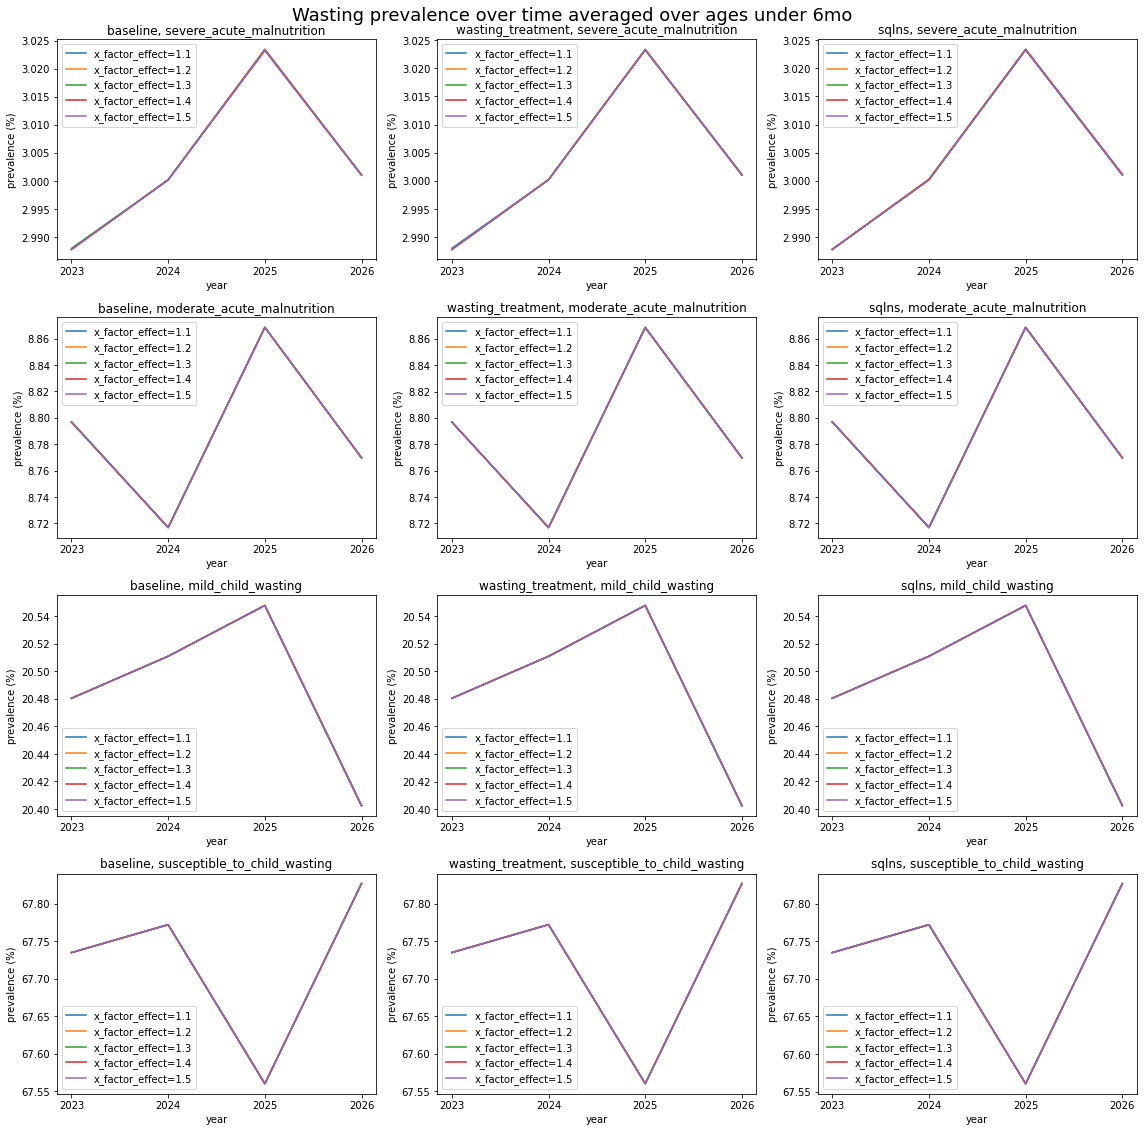

In [44]:
plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age_under_6mo,
    'x_factor_effect',
    "prevalence (%)",
    "Wasting prevalence over time averaged over ages under 6mo",
    uncertainty=False,
);

In [45]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_under_6mo_averaged.pdf")

In [46]:
wasting_prevalence_by_year_under_6mo = csr.get_prevalence(
    data, 'wasting', strata=['year'], prefilter_query=f"age not in {over_6mo}", multiplier=100
)
wasting_prevalence_by_year_under_6mo

year  input_draw           scenario  x_factor_effect  \
0     2022          29           baseline              1.1   
1     2022          29           baseline              1.1   
2     2022          29           baseline              1.1   
3     2022          29           baseline              1.1   
...    ...         ...                ...              ...   
3596  2026         946  wasting_treatment              1.5   
3597  2026         946  wasting_treatment              1.5   
3598  2026         946  wasting_treatment              1.5   
3599  2026         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  20.413580  state_person_time   
1      moderate_acute_malnutrition   8.983827  state_person_time   
2        severe_acute_malnutrition   3.054449  state_person_time   
3     susceptible_to_child_wasting  67.548145  state_person_time   
...                            ...        ...                ...   
3596            mild_child_wasting  19.843546  state_person_time   
3597   moderate_acute_malnutrition   9.063447  state_person_time   
3598     severe_acute_malnutrition   3.235735  state_person_time   
3599  susceptible_to_child_wasting  67.857272  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
3596         person_time         100  
3597         person_time         100  
3598         person_time         100  
3599         person_time         100  

[3600 rows x 9 columns]

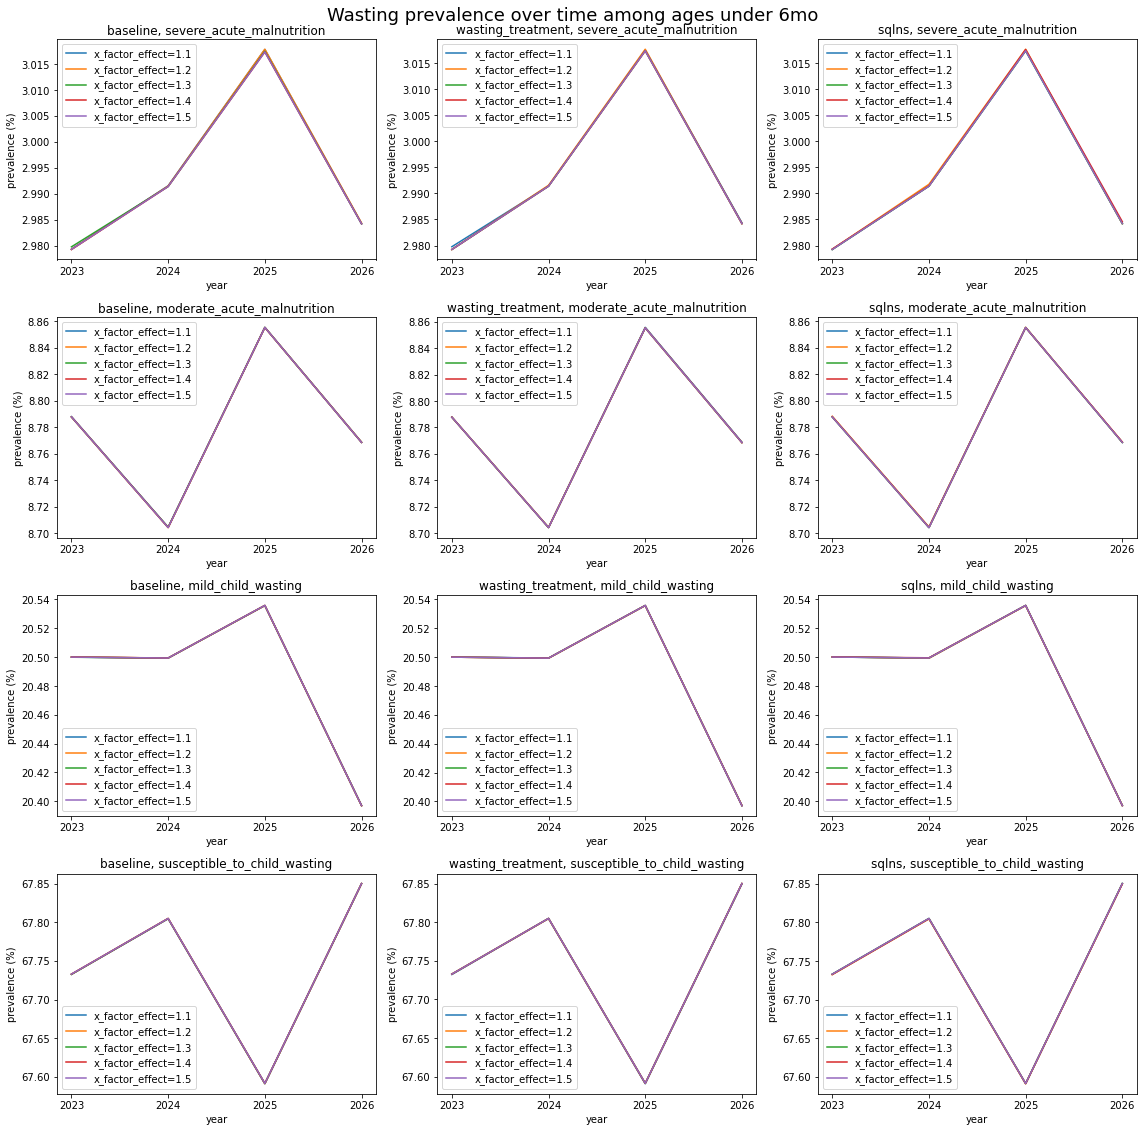

In [47]:
fig= plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_under_6mo.query("year>'2022'"), 
    'x_factor_effect', 
    "prevalence (%)",
    "Wasting prevalence over time among ages under 6mo",
    uncertainty=False,
)

In [48]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_age_under_6mo.pdf")

# Plot wasting prevalence by age group

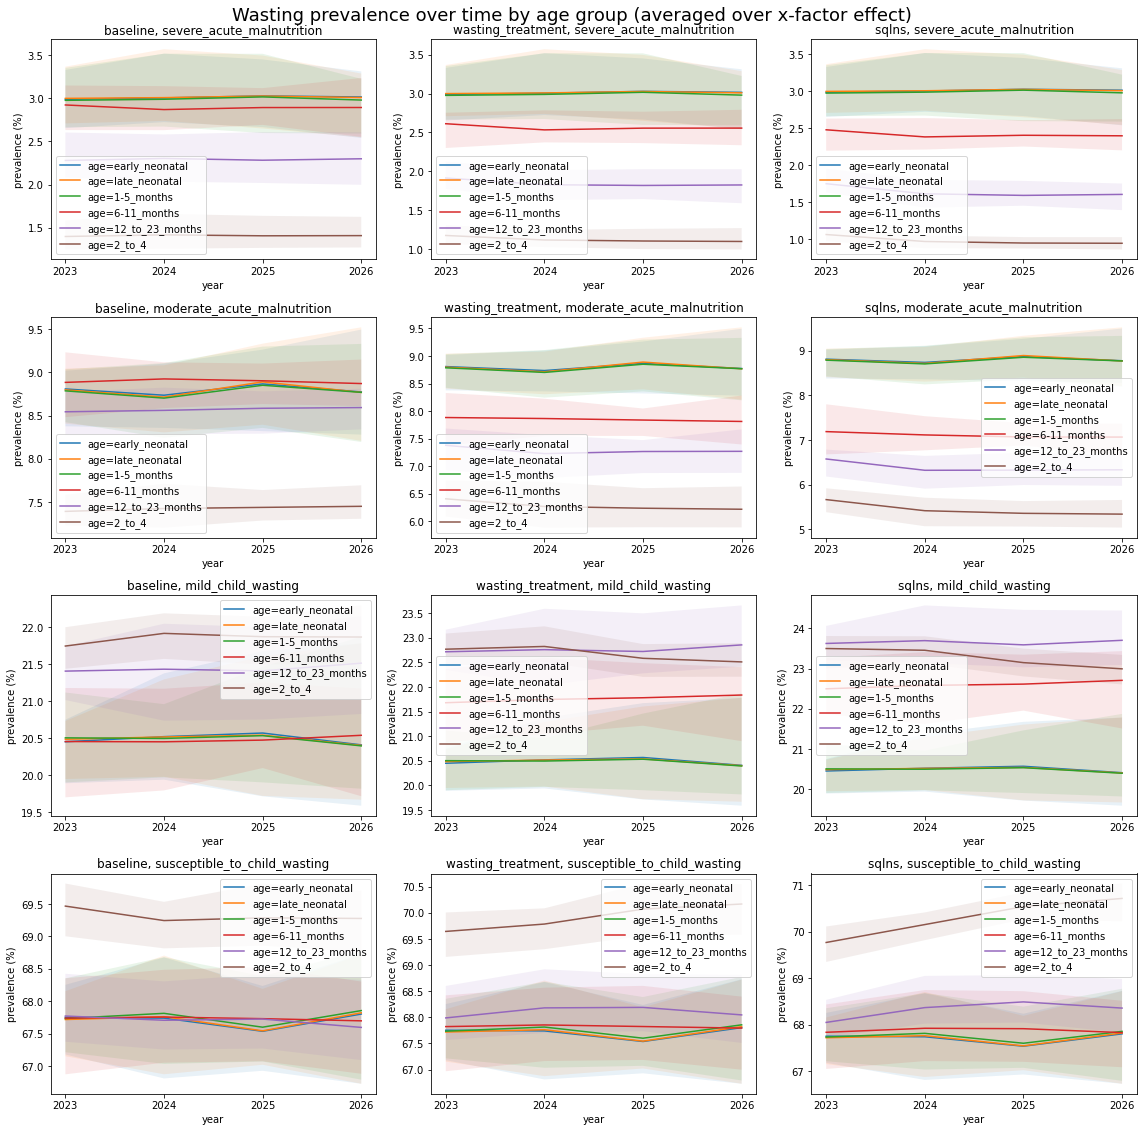

In [49]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022'"),
    'age',
    "prevalence (%)",
    "Wasting prevalence over time by age group (averaged over x-factor effect)"
);

In [50]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_age_group_averaged_over_x_factor.pdf")

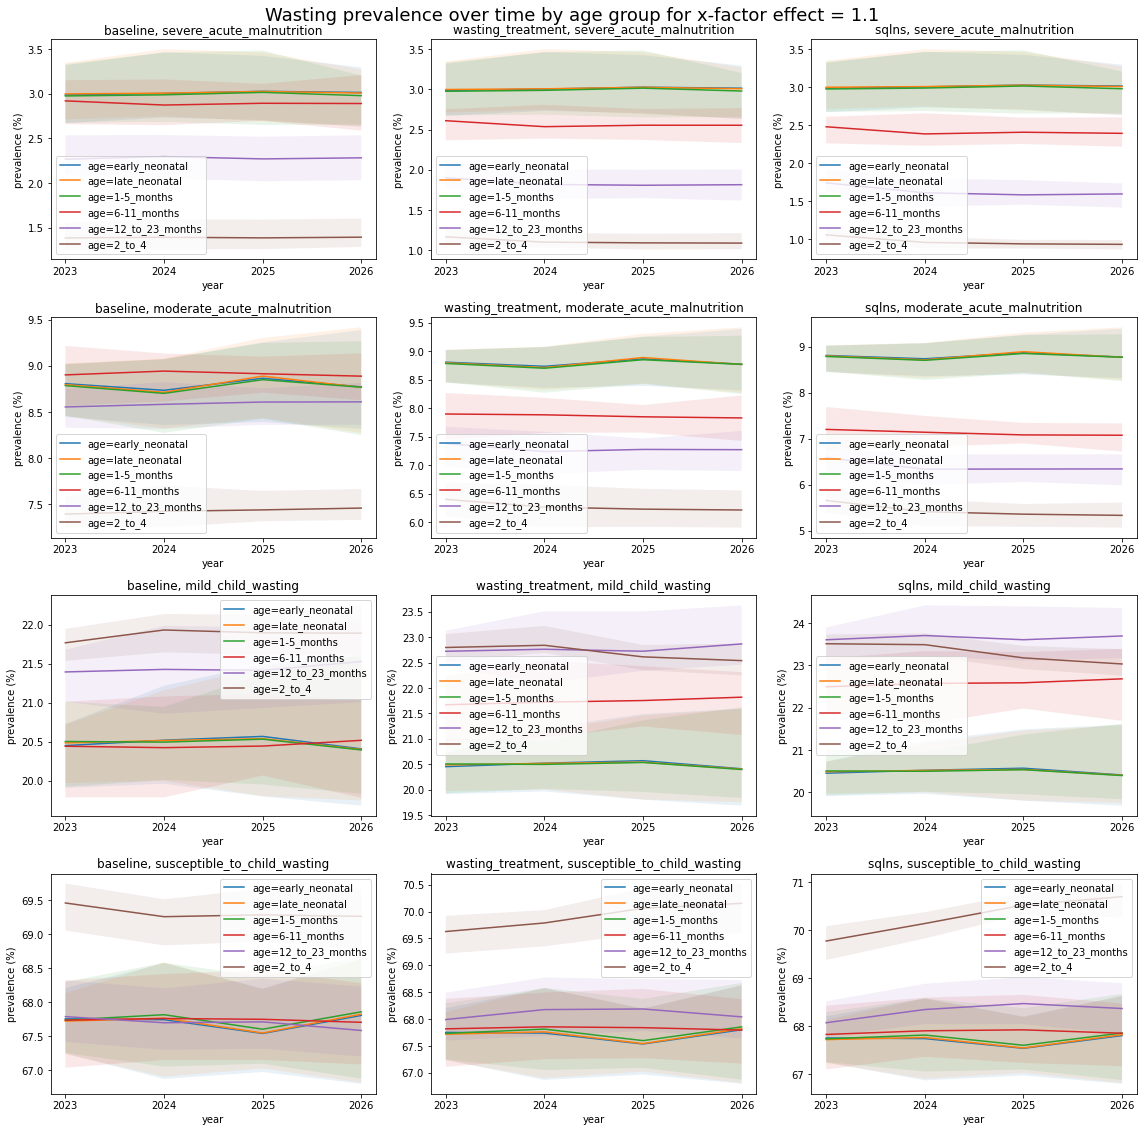

In [51]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022' and x_factor_effect==1.1"),
    'age',
    "prevalence (%)",
    "Wasting prevalence over time by age group for x-factor effect = 1.1");

In [52]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_age_group_x_factor_1.1.pdf")

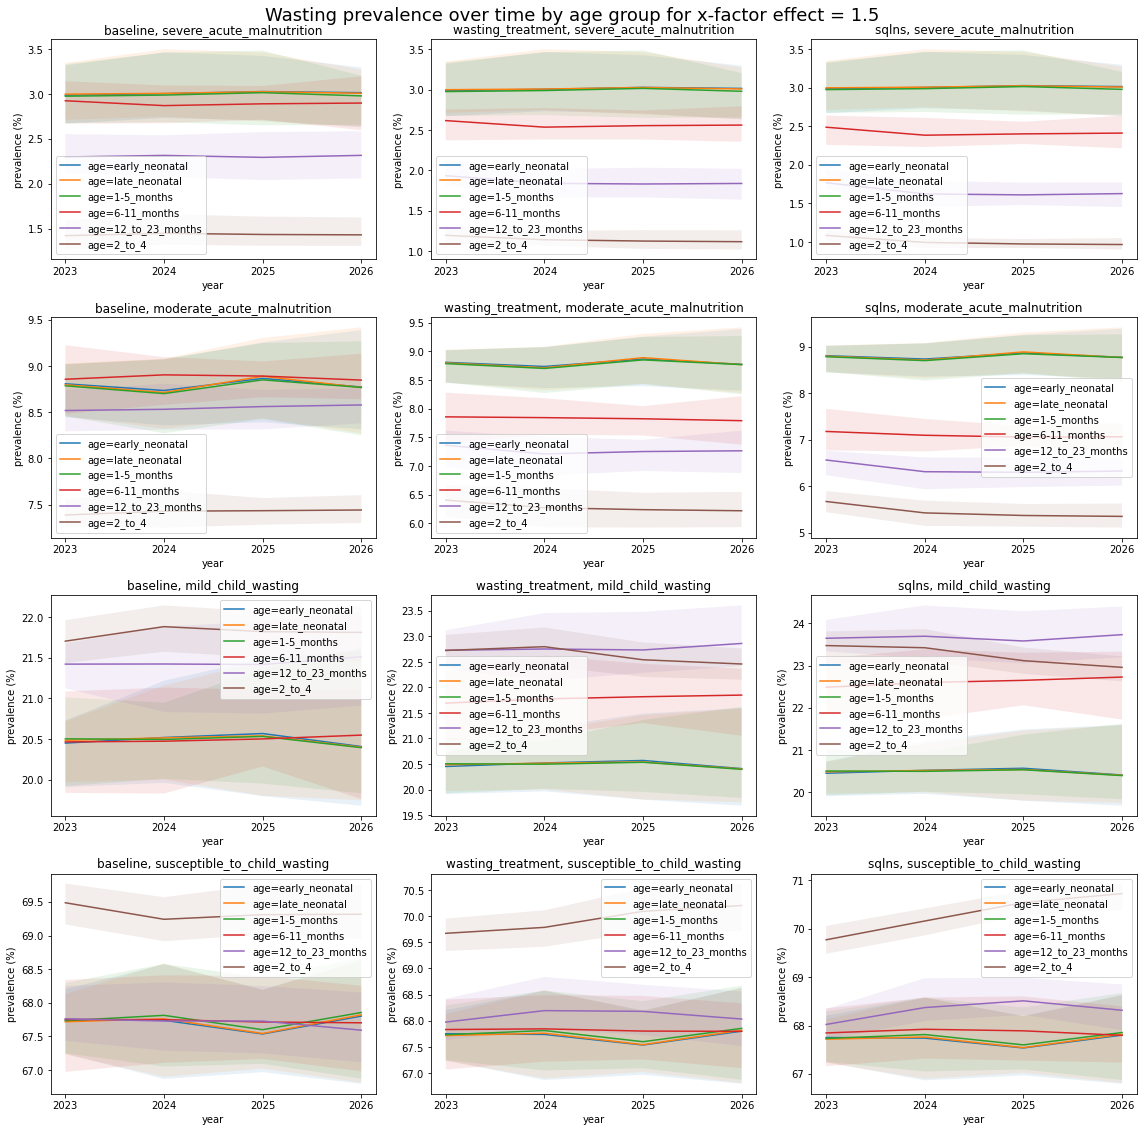

In [53]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_age.query("year>'2022' and x_factor_effect==1.5"),
    'age',
    "prevalence (%)",
    "Wasting prevalence over time by age group for x-factor effect = 1.5");

In [54]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_age_group_x_factor_1.5.pdf")

# Plot prevalence stratified by X-factor

In [55]:
wasting_prevalence_by_year_and_x_factor = csr.get_prevalence(
    data, 'wasting', strata=['year', 'x_factor'], multiplier=100)
wasting_prevalence_by_year_and_x_factor

year x_factor  input_draw           scenario  x_factor_effect  \
0     2022     cat1          29           baseline              1.1   
1     2022     cat1          29           baseline              1.1   
2     2022     cat1          29           baseline              1.1   
3     2022     cat1          29           baseline              1.1   
...    ...      ...         ...                ...              ...   
7196  2026     cat2         946  wasting_treatment              1.5   
7197  2026     cat2         946  wasting_treatment              1.5   
7198  2026     cat2         946  wasting_treatment              1.5   
7199  2026     cat2         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  21.111546  state_person_time   
1      moderate_acute_malnutrition   8.448058  state_person_time   
2        severe_acute_malnutrition   2.102739  state_person_time   
3     susceptible_to_child_wasting  68.337657  state_person_time   
...                            ...        ...                ...   
7196            mild_child_wasting  21.659315  state_person_time   
7197   moderate_acute_malnutrition   6.367302  state_person_time   
7198     severe_acute_malnutrition   1.384787  state_person_time   
7199  susceptible_to_child_wasting  70.588597  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
7196         person_time         100  
7197         person_time         100  
7198         person_time         100  
7199         person_time         100  

[7200 rows x 10 columns]

In [56]:
# Check that my function is working like I expect
vp.ratio(
    data.wasting_state_person_time,
    data.person_time,
    strata=['year', 'x_factor'],
    numerator_broadcast='wasting_state', # Compute prevalence of all categories simultaneously
    multiplier=100, # Convert units to percent
).equals(wasting_prevalence_by_year_and_x_factor)

True

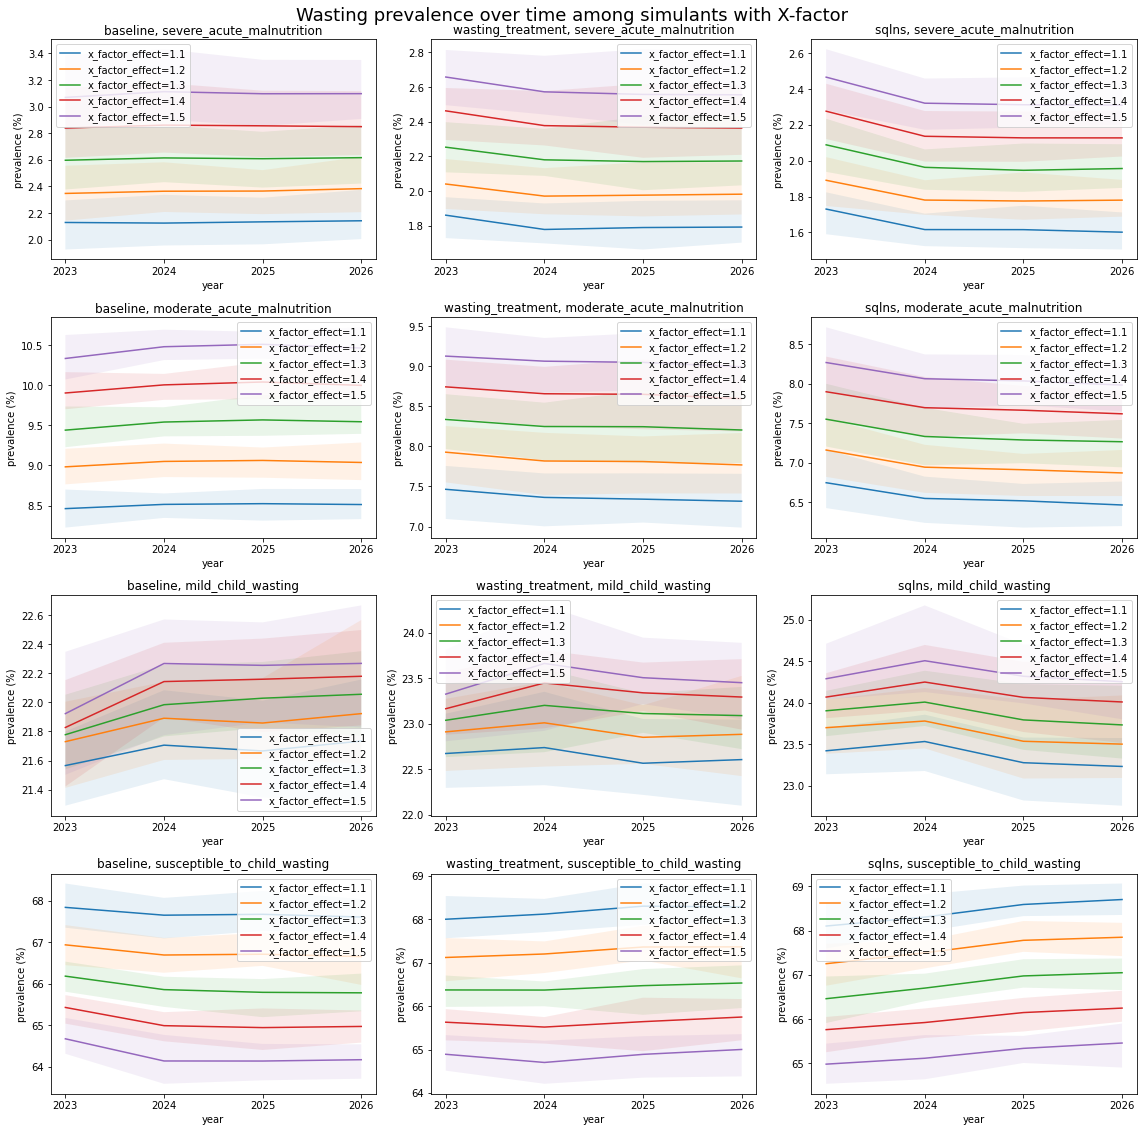

In [57]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_x_factor.query("year>'2022' and x_factor=='cat1'"),
    'x_factor_effect',
    "prevalence (%)",
    "Wasting prevalence over time among simulants with X-factor");

In [58]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_among_x_factor.pdf")

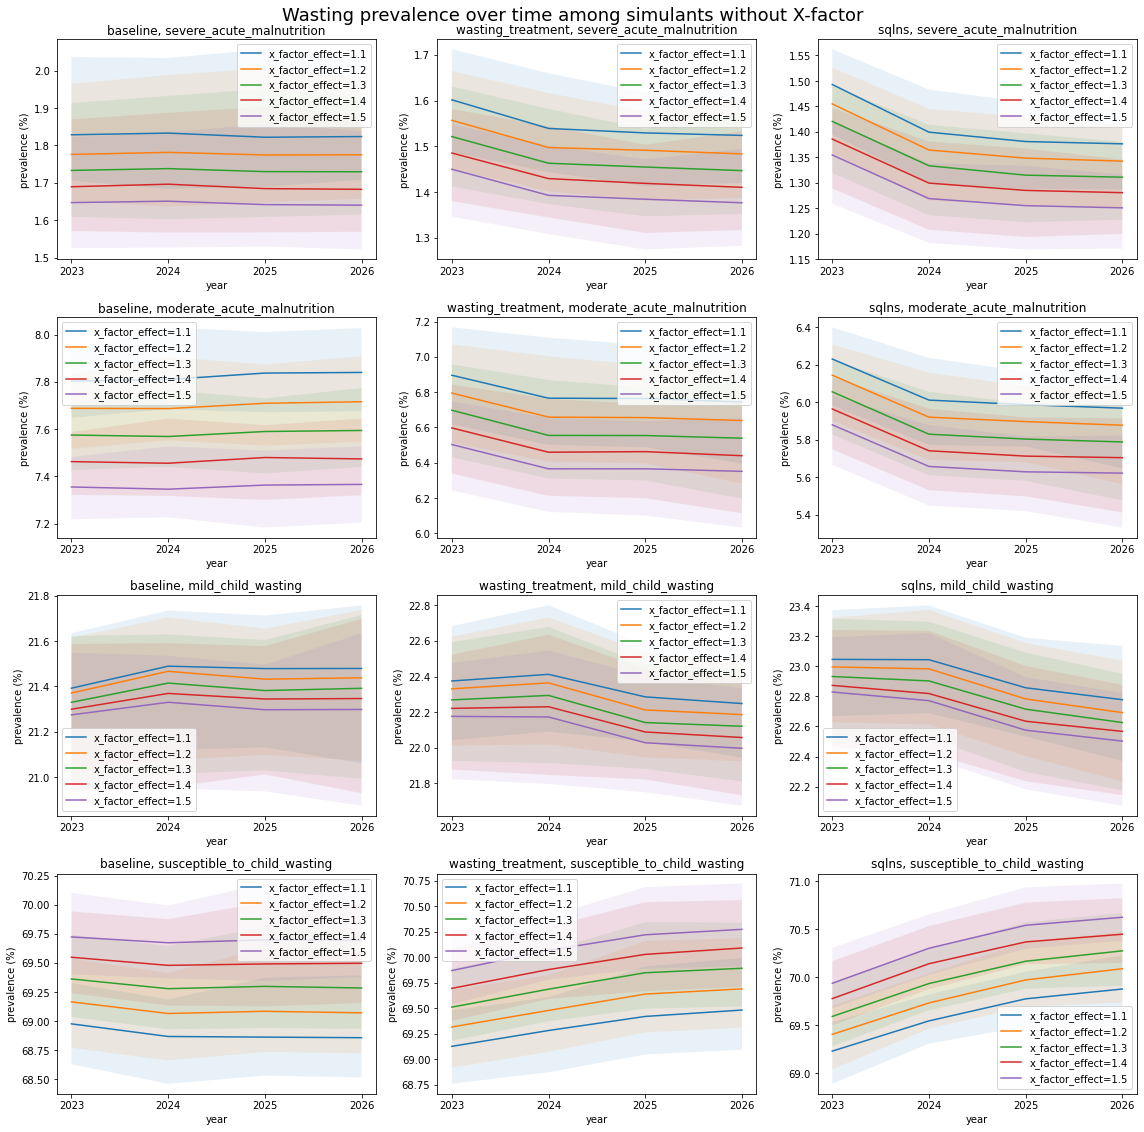

In [59]:
fig = plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_prevalence_by_year_and_x_factor.query("year>'2022' and x_factor=='cat2'"),
    'x_factor_effect',
    "prevalence (%)",
    "Wasting prevalence over time among simulants without X-factor");

In [60]:
for directory in [output_dir, j_output_dir]:
    fig.savefig(f"{directory}/wasting_prevalence_by_x_factor_among_no_x_factor.pdf")

# Test random things

## Trying to come up with a way to return all rows with `.query()`

https://stackoverflow.com/questions/46822423/pandas-dataframe-query-expression-that-returns-all-rows-by-default

https://github.com/pandas-dev/pandas/issues/37941

There is no good way to do it.

In [61]:
slice(None)

slice(None, None, None)

In [62]:
ALL = slice(None)
wasting_prevalence_by_year_and_x_factor.query("@ALL", engine='python')

year x_factor  input_draw           scenario  x_factor_effect  \
0     2022     cat1          29           baseline              1.1   
1     2022     cat1          29           baseline              1.1   
2     2022     cat1          29           baseline              1.1   
3     2022     cat1          29           baseline              1.1   
...    ...      ...         ...                ...              ...   
7196  2026     cat2         946  wasting_treatment              1.5   
7197  2026     cat2         946  wasting_treatment              1.5   
7198  2026     cat2         946  wasting_treatment              1.5   
7199  2026     cat2         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  21.111546  state_person_time   
1      moderate_acute_malnutrition   8.448058  state_person_time   
2        severe_acute_malnutrition   2.102739  state_person_time   
3     susceptible_to_child_wasting  68.337657  state_person_time   
...                            ...        ...                ...   
7196            mild_child_wasting  21.659315  state_person_time   
7197   moderate_acute_malnutrition   6.367302  state_person_time   
7198     severe_acute_malnutrition   1.384787  state_person_time   
7199  susceptible_to_child_wasting  70.588597  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
7196         person_time         100  
7197         person_time         100  
7198         person_time         100  
7199         person_time         100  

[7200 rows x 10 columns]

In [63]:
wasting_prevalence_by_year_and_x_factor.query("tuple()", engine='python')

year x_factor  input_draw           scenario  x_factor_effect  \
0     2022     cat1          29           baseline              1.1   
1     2022     cat1          29           baseline              1.1   
2     2022     cat1          29           baseline              1.1   
3     2022     cat1          29           baseline              1.1   
...    ...      ...         ...                ...              ...   
7196  2026     cat2         946  wasting_treatment              1.5   
7197  2026     cat2         946  wasting_treatment              1.5   
7198  2026     cat2         946  wasting_treatment              1.5   
7199  2026     cat2         946  wasting_treatment              1.5   

                     wasting_state      value  numerator_measure  \
0               mild_child_wasting  21.111546  state_person_time   
1      moderate_acute_malnutrition   8.448058  state_person_time   
2        severe_acute_malnutrition   2.102739  state_person_time   
3     susceptible_to_child_wasting  68.337657  state_person_time   
...                            ...        ...                ...   
7196            mild_child_wasting  21.659315  state_person_time   
7197   moderate_acute_malnutrition   6.367302  state_person_time   
7198     severe_acute_malnutrition   1.384787  state_person_time   
7199  susceptible_to_child_wasting  70.588597  state_person_time   

     denominator_measure  multiplier  
0            person_time         100  
1            person_time         100  
2            person_time         100  
3            person_time         100  
...                  ...         ...  
7196         person_time         100  
7197         person_time         100  
7198         person_time         100  
7199         person_time         100  

[7200 rows x 10 columns]

## Write a function to split the list of ordered age groups into bins

In [64]:
def get_age_group_bins(*cut_points):
    cut_points = [csr.ages_categorical[0], *cut_points]
#     print(cut_points, list(zip(cut_points[:-1], cut_points[1:])))
    bins = [
#         print(start, stop)
        csr.ages_categorical[(csr.ages_categorical>=start) & (csr.ages_categorical<stop)]
        for start, stop in zip(cut_points[:-1], cut_points[1:])
    ] + [csr.ages_categorical[csr.ages_categorical>=cut_points[-1]]]
    return tuple(bins)
print(get_age_group_bins(), '\n')
print(get_age_group_bins('early_neonatal'), '\n')
print(get_age_group_bins('12_to_23_months'), '\n')
print(get_age_group_bins('6-11_months', 'all_ages'))

(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months', '12_to_23_months', '2_to_4', 'all_ages']
Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages'],) 

([], Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages'], ['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months', '12_to_23_months', '2_to_4', 'all_ages']
Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages']) 

(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months']
Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages'], ['12_to_23_months', '2_to_4', 'all_ages']
Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4'

In [65]:
def test_unpacking(*args):
    print(args)
test_unpacking()
test_unpacking(1)
test_unpacking(1,4,5)

()
(1,)
(1, 4, 5)


## Try loading `keyspace.yaml`

In [66]:
import yaml

In [67]:
model_path = '/share/costeffectiveness/results/vivarium_ciff_sam/v4.5.2_x_factor/ciff_sam/2021_09_29_12_12_47'
with open(f"{model_path}/keyspace.yaml", 'r') as file:
    keyspace = yaml.load(file, Loader=yaml.SafeLoader)
keyspace

{'effect_of_x_factor_on_mild_child_wasting.incidence_rate.relative_risk': [1.1,
  1.4,
  1.3,
  1.2,
  1.5],
 'effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition.transition_rate.relative_risk': [1.1,
  1.4,
  1.3,
  1.2,
  1.5],
 'effect_of_x_factor_on_moderate_acute_malnutrition_to_severe_acute_malnutrition.transition_rate.relative_risk': [1.1,
  1.4,
  1.3,
  1.2,
  1.5],
 'input_draw': [602, 357, 946, 829, 650, 232, 394, 680, 629, 29, 223, 524],
 'intervention.scenario': ['wasting_treatment', 'sqlns', 'baseline'],
 'random_seed': [44, 97, 24, 12, 7, 5, 70, 36, 29, 49]}

In [68]:
pd.json_normalize(keyspace).T

0
effect_of_x_factor_on_mild_child_wasting.incide...                          [1.1, 1.4, 1.3, 1.2, 1.5]
effect_of_x_factor_on_mild_child_wasting_to_mod...                          [1.1, 1.4, 1.3, 1.2, 1.5]
effect_of_x_factor_on_moderate_acute_malnutriti...                          [1.1, 1.4, 1.3, 1.2, 1.5]
input_draw                                          [602, 357, 946, 829, 650, 232, 394, 680, 629, ...
intervention.scenario                                            [wasting_treatment, sqlns, baseline]
random_seed                                                    [44, 97, 24, 12, 7, 5, 70, 36, 29, 49]

In [69]:
type(keyspace)

dict

In [70]:
keyspace.keys()

dict_keys(['effect_of_x_factor_on_mild_child_wasting.incidence_rate.relative_risk', 'effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition.transition_rate.relative_risk', 'effect_of_x_factor_on_moderate_acute_malnutrition_to_severe_acute_malnutrition.transition_rate.relative_risk', 'input_draw', 'intervention.scenario', 'random_seed'])

In [71]:
keyspace['input_draw']

[602, 357, 946, 829, 650, 232, 394, 680, 629, 29, 223, 524]

In [72]:
keyspace['random_seed']

[44, 97, 24, 12, 7, 5, 70, 36, 29, 49]